In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import os
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import dimod
import dwave
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
import dwave_networkx as dnx
import minorminer
import embera

from src.particle_funcs import distance_matrix as distance_matrix
import src.leap_funcs.qubo.q_matrix as q_matrix

from src import leap_funcs as leap_funcs
from src.leap_funcs import embedding_quality

from src import h5py_funcs
from src.h5py_funcs import discoveries, init_custom_getstates, io

Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.


In [2]:
with open('../API_Token_Oliver_Dev.txt') as file:
    token = file.readline().rstrip()
    architecture = file.readline().rstrip()
sampler = DWaveSampler(token = token, architecture='pegasus', region='eu-central-1')
tmp_not_needed_as_a_variable = sampler.adjacency # required for sampler having all data needed for __getstate__, no idea why this is necessary
sampler_graph = sampler.to_networkx_graph()

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]


C:\Users\oahre\AppData\Local\Temp\ipykernel_20272\2776199921.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_initial.show()


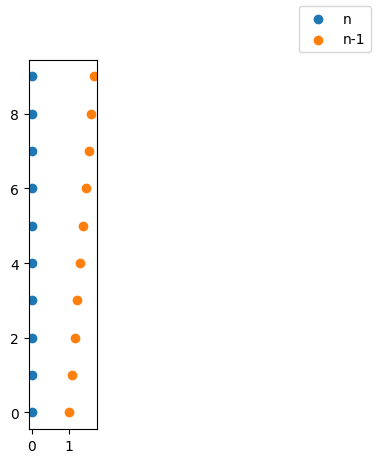

In [3]:
num_particles = 10

part_coords_n = np.zeros((num_particles,2))
part_coords_nm1 = np.zeros((num_particles,2))

for i in range(np.shape(part_coords_n)[0]):
    part_coords_n[i,:] = [0, i]
    part_coords_nm1[i,:] = [1.0*1+0.075*i, i]

fig_initial, axs_initial = plt.subplots(1,1)
axs_initial.scatter(part_coords_n[:,0], part_coords_n[:,1], label="n")
axs_initial.scatter(part_coords_nm1[:,0], part_coords_nm1[:,1], label="n-1")
axs_initial.set_aspect('equal')
fig_initial.legend()
fig_initial.show()

correct_sol = np.zeros(num_particles*num_particles)
for i in range(1, num_particles+1):
    correct_sol[(i-1)*num_particles + i -1] = 1.

print(correct_sol)

In [4]:
distances = distance_matrix.calc_phi_ij(part_coords_n, part_coords_nm1)
Q_dist_diag = q_matrix.q_dist_diag(distances)
Q_part = q_matrix.q_part(np.shape(distances)[0])
Q_pos = q_matrix.q_pos(np.shape(distances)[0])
Q_array = Q_dist_diag + Q_part + Q_pos
Q_dict = q_matrix.Q_convert_to_dict(Q_array)
#with np.printoptions(precision=3, linewidth=1000, threshold=1e6):
#    print(Q_array)

In [5]:
layout_source = {i: val for i, val in enumerate(part_coords_n)}
layout_source = {}
for i in range(num_particles):
    for j in range(num_particles):
        layout_source[i*num_particles + j +1] = (part_coords_nm1[j,0], part_coords_nm1[j,1])
print(layout_source)

{1: (1.0, 0.0), 2: (1.075, 1.0), 3: (1.15, 2.0), 4: (1.225, 3.0), 5: (1.3, 4.0), 6: (1.375, 5.0), 7: (1.45, 6.0), 8: (1.525, 7.0), 9: (1.6, 8.0), 10: (1.6749999999999998, 9.0), 11: (1.0, 0.0), 12: (1.075, 1.0), 13: (1.15, 2.0), 14: (1.225, 3.0), 15: (1.3, 4.0), 16: (1.375, 5.0), 17: (1.45, 6.0), 18: (1.525, 7.0), 19: (1.6, 8.0), 20: (1.6749999999999998, 9.0), 21: (1.0, 0.0), 22: (1.075, 1.0), 23: (1.15, 2.0), 24: (1.225, 3.0), 25: (1.3, 4.0), 26: (1.375, 5.0), 27: (1.45, 6.0), 28: (1.525, 7.0), 29: (1.6, 8.0), 30: (1.6749999999999998, 9.0), 31: (1.0, 0.0), 32: (1.075, 1.0), 33: (1.15, 2.0), 34: (1.225, 3.0), 35: (1.3, 4.0), 36: (1.375, 5.0), 37: (1.45, 6.0), 38: (1.525, 7.0), 39: (1.6, 8.0), 40: (1.6749999999999998, 9.0), 41: (1.0, 0.0), 42: (1.075, 1.0), 43: (1.15, 2.0), 44: (1.225, 3.0), 45: (1.3, 4.0), 46: (1.375, 5.0), 47: (1.45, 6.0), 48: (1.525, 7.0), 49: (1.6, 8.0), 50: (1.6749999999999998, 9.0), 51: (1.0, 0.0), 52: (1.075, 1.0), 53: (1.15, 2.0), 54: (1.225, 3.0), 55: (1.3, 4.0)

In [6]:
#tries (int, default=1):
#verbose (int, default=0): Verbosity level
#    0: Quiet mode
#    1: Print statements
#    4: Tile drawings with concentrati
#layout ({<node>:(<x>,<y>),...}, default=None):
#    Dict of 2D positions assigned to the source graph node
#vicinity (int, default=3): Granularity of the candidate assignment.
#    0: Single tile
#    1: Immediate neighbors = (north, south, east, west)
#    2: Extended neighbors = (Immediate) + diagonals
#    3: Directed  = (Single) + 3 tiles closest to the node coordinat
#viscosity (float, default=0.00
#delta_t (float, default=0.20): Time delta for every diffusion ste
#d_lim (float<=1.0, default=0.75): Density limity for each til
#downscale (bool, default=False): Scale of initial overlay is calculated
#    from the problem/target size ratio, and expected occupancy _a
#    i.e. (Y,X) = 2 + (M,N)*(P_size*_a/T_size
#keep_ratio (bool or float<=1.0, default=False): When scaling, keep
#    aspect ratio. If a float is given, the value is used to scale
#    the problem layout in the dimension that is not restricted by
#    the target dimension
#expected_occupancy (float, default=2.5): Number of qubits expected
#    to be used per problem node on average.


In [7]:
_file_name = 'analyzes_parts_{}_09.h5'.format(num_particles)

kwargs_diffusion_candidates = {
    'tries':20, 
    'verbose':1,
    'layout':layout_source,
    #'vicinity':3,
    #'viscosity':,
    #'delta_t':,
    #'d_lim':,
    #'downscale':,
    #'keep_ratio':,
    #'expected_occupancy':
    }
timings_candidates = {}

kwargs_minorminer = {
        'max_no_improvement':250,
        #random_seed=None,
        #timeout=1000,
        #max_beta=None,
        'tries':250,
        #inner_rounds=None,
        'chainlength_patience':250,
        #max_fill=None,
        #threads=1,
        #return_overlap=False,
        #skip_initialization=False,
        #verbose=0,
        #interactive=False,
        #initial_chains=(),
        #fixed_chains=(),
        #restrict_chains=(),
        #suspend_chains=(),
}
timings_embedding = {}

In [8]:
Q_dict_graph = nx.Graph(list(Q_dict))
Q_dict_edgelist = list(Q_dict_graph.edges())
#Q_dict_edgelist = [(item, item[::-1]) for item in Q_dict_edgelist]
#layout_dummy = {v:v for v in Q_dict_graph.graph}
#layout = dnx.drawing.pegasus_layout(sampler_graph) # x y coordinates of the nodes
#print(Q_dict_graph)
#print(Q_dict_edgelist)
#print(layout)

kwargs_wo_layout = kwargs_diffusion_candidates.copy()
kwargs_wo_layout.pop('layout')
#print(kwargs_wo_layout)
#print(kwargs_diffusion_candidates)

tic = time.time()
candidates_em = embera.preprocess.diffusion_placer.find_candidates(Q_dict_edgelist, sampler_graph, **kwargs_wo_layout)#, layout=layout)
toc = time.time()
timings_candidates['em'] = toc-tic

tic = time.time()
candidates_em_wo_migration = embera.preprocess.diffusion_placer.find_candidates(Q_dict_edgelist, sampler_graph, enable_migration=False, **kwargs_wo_layout)#, layout=layout)
toc = time.time()
timings_candidates['em_wo_migration'] = toc-tic

tic = time.time()
candidates_em_layout = embera.preprocess.diffusion_placer.find_candidates(Q_dict_edgelist, sampler_graph, **kwargs_diffusion_candidates)
toc = time.time()
timings_candidates['em_layout'] = toc-tic

tic = time.time()
candidates_em_wo_migration_layout = embera.preprocess.diffusion_placer.find_candidates(Q_dict_edgelist, sampler_graph, enable_migration=False, **kwargs_diffusion_candidates)
toc = time.time()
timings_candidates['em_wo_migration_layout'] = toc-tic


print(len(candidates_em))
print(len(candidates_em_wo_migration))
print(len(candidates_em_layout))
print(len(candidates_em_wo_migration_layout))

100
100
100
100


d:\onedriverwth\rwth\simulation_sciences\masterthesis\04_code\quantum_annealing_for_particle_matching\ext\embera\embera\preprocess\diffusion_placer.py:34: UserWarning: A spring layout of the unweighted graph was generated using NetworkX.
  warnings.warn("A spring layout of the unweighted graph"


In [9]:
#max_no_improvement=10,
#random_seed=None,
#timeout=1000,
#max_beta=None,
#tries=10,
#inner_rounds=None,
#chainlength_patience=10,
#max_fill=None,
#threads=1,
#return_overlap=False,
#skip_initialization=False,
#verbose=0,
#interactive=False,
#initial_chains=(),
#fixed_chains=(),
#restrict_chains=(),
#suspend_chains=(),

#kwargs_minorminer = {
#        'max_no_improvement':100,
#        #random_seed=None,
#        #timeout=1000,
#        #max_beta=None,
#        'tries':100,
#        #inner_rounds=None,
#        'chainlength_patience':100,
#        #max_fill=None,
#        #threads=1,
#        #return_overlap=False,
#        #skip_initialization=False,
#        #verbose=0,
#        #interactive=False,
#        #initial_chains=(),
#        #fixed_chains=(),
#        #restrict_chains=(),
#        #suspend_chains=(),
#}



In [10]:
# minorminer

tic = time.time()
embedding_mm = minorminer.find_embedding(S=Q_dict, T=sampler_graph, interactive=True, verbose=1, **kwargs_minorminer)
toc = time.time()
timings_embedding['mm'] = toc-tic
print(type(embedding_mm))
print(embedding_mm)
print(type([key for key in embedding_mm.keys()][0]))
print(type(embedding_mm[1]))
print(type(embedding_mm[1][0]))

initialized
max qubit fill 2; num maxfull qubits=16
embedding trial 1
embedding found.
max chain length 38; num max chains=1
reducing chain lengths
max chain length 28; num max chains=1
max chain length 27; num max chains=1
max chain length 26; num max chains=2
max chain length 25; num max chains=2
max chain length 24; num max chains=1
max chain length 23; num max chains=1
max chain length 21; num max chains=3
max chain length 20; num max chains=1
max chain length 18; num max chains=3
max chain length 16; num max chains=2
max chain length 15; num max chains=1
max chain length 14; num max chains=8
max chain length 13; num max chains=5
max chain length 12; num max chains=5
max chain length 11; num max chains=10
<class 'dict'>
{1: [4046, 4045, 2135, 4047, 2134, 4048], 2: [1774, 3714, 3715, 3716, 3717, 3718, 3864], 3: [2284, 3822, 3823, 3821], 4: [3743, 1445, 3742, 1444, 1446, 1447, 3744, 3747, 3745, 3746, 4117], 5: [4584, 2329, 4585, 4586, 4587, 2333, 2332, 2331, 2330, 1778], 6: [1984, 19

In [11]:
tic = time.time()
embedding_em = minorminer.find_embedding(Q_dict, sampler_graph, initial_chains=candidates_em, interactive=True, verbose=1, **kwargs_minorminer)
toc = time.time()
timings_embedding['em'] = toc-tic

initialized
max qubit fill 2; num maxfull qubits=43
embedding trial 1
embedding found.
max chain length 37; num max chains=1
reducing chain lengths
max chain length 36; num max chains=1
max chain length 35; num max chains=3
max chain length 34; num max chains=2
max chain length 33; num max chains=2
max chain length 31; num max chains=1
max chain length 25; num max chains=1
max chain length 24; num max chains=1
max chain length 23; num max chains=1
max chain length 21; num max chains=2
max chain length 20; num max chains=1
max chain length 19; num max chains=1
max chain length 18; num max chains=1
max chain length 17; num max chains=3
max chain length 16; num max chains=2
max chain length 15; num max chains=4
max chain length 14; num max chains=3
max chain length 13; num max chains=4
max chain length 12; num max chains=8
max chain length 11; num max chains=2
max chain length 10; num max chains=10


In [12]:
tic = time.time()
embedding_em_wo_migration = minorminer.find_embedding(Q_dict, sampler_graph, initial_chains=candidates_em_wo_migration, interactive=True, verbose=1, **kwargs_minorminer)
toc = time.time()
timings_embedding['em_wo_migration'] = toc-tic

initialized
max qubit fill 2; num maxfull qubits=4
embedding trial 1
embedding found.
max chain length 76; num max chains=1
reducing chain lengths
max chain length 75; num max chains=1
max chain length 72; num max chains=1
max chain length 30; num max chains=1
max chain length 25; num max chains=4
max chain length 24; num max chains=1
max chain length 23; num max chains=1
max chain length 20; num max chains=2
max chain length 19; num max chains=2
max chain length 18; num max chains=1
max chain length 17; num max chains=1
max chain length 16; num max chains=1
max chain length 15; num max chains=1
max chain length 14; num max chains=2
max chain length 13; num max chains=2
max chain length 12; num max chains=5
max chain length 11; num max chains=10
max chain length 10; num max chains=9


In [13]:
tic = time.time()
embedding_em_layout = minorminer.find_embedding(Q_dict, sampler_graph, initial_chains=candidates_em_layout, interactive=True, verbose=1, **kwargs_minorminer)
toc = time.time()
timings_embedding['em_layout'] = toc-tic

initialized
max qubit fill 3; num maxfull qubits=26
embedding trial 1
max qubit fill 2; num maxfull qubits=57
embedding found.
max chain length 59; num max chains=1
reducing chain lengths
max chain length 58; num max chains=1
max chain length 43; num max chains=1
max chain length 22; num max chains=2
max chain length 21; num max chains=1
max chain length 20; num max chains=2
max chain length 19; num max chains=2
max chain length 18; num max chains=1
max chain length 17; num max chains=4
max chain length 16; num max chains=2
max chain length 15; num max chains=3
max chain length 13; num max chains=7
max chain length 12; num max chains=8
max chain length 11; num max chains=5
max chain length 10; num max chains=8
max chain length 9; num max chains=13


In [14]:
tic = time.time()
embedding_em_wo_migration_layout = minorminer.find_embedding(Q_dict, sampler_graph, initial_chains=candidates_em_wo_migration_layout, interactive=True, verbose=1, **kwargs_minorminer)
toc = time.time()
timings_embedding['em_wo_migration_layout'] = toc-tic

initialized
max qubit fill 7; num maxfull qubits=32
embedding trial 1
max qubit fill 6; num maxfull qubits=31
max qubit fill 5; num maxfull qubits=31
max qubit fill 4; num maxfull qubits=31
max qubit fill 3; num maxfull qubits=31
max qubit fill 2; num maxfull qubits=31
embedding found.
max chain length 55; num max chains=1
reducing chain lengths
max chain length 54; num max chains=1
max chain length 53; num max chains=1
max chain length 39; num max chains=2
max chain length 26; num max chains=2
max chain length 24; num max chains=1
max chain length 23; num max chains=1
max chain length 20; num max chains=1
max chain length 17; num max chains=4
max chain length 16; num max chains=1
max chain length 15; num max chains=1
max chain length 14; num max chains=3
max chain length 13; num max chains=1
max chain length 12; num max chains=9
max chain length 11; num max chains=4
max chain length 10; num max chains=9
max chain length 9; num max chains=13


In [15]:
%matplotlib qt5
kwargs_plot = {'with_labels':False, 'show_labels':False, 'crosses':True}
fig, axs = plt.subplots(1,1)
dnx.draw_pegasus_embedding(sampler_graph, emb=embedding_mm, embedded_graph=Q_dict_graph, **kwargs_plot, ax=axs)
plt.show()

In [16]:
%matplotlib qt5
fig, axs = plt.subplots(1,1)
dnx.draw_pegasus_embedding(sampler_graph, emb=embedding_em, embedded_graph=Q_dict_graph, **kwargs_plot, ax=axs)
plt.show()

In [17]:
%matplotlib qt5
fig, axs = plt.subplots(1,1)
dnx.draw_pegasus_embedding(sampler_graph, emb=embedding_em_wo_migration, embedded_graph=Q_dict_graph, **kwargs_plot, ax=axs)
plt.show()

In [18]:
%matplotlib qt5
fig, axs = plt.subplots(1,1)
dnx.draw_pegasus_embedding(sampler_graph, emb=embedding_em_layout, embedded_graph=Q_dict_graph, **kwargs_plot, ax=axs)
plt.show()

In [19]:
%matplotlib qt5
fig, axs = plt.subplots(1,1)
dnx.draw_pegasus_embedding(sampler_graph, emb=embedding_em_wo_migration_layout, embedded_graph=Q_dict_graph, **kwargs_plot, ax=axs)
plt.show()

In [23]:
print(sampler.properties['annealing_time_range'])
print(sampler.properties['default_annealing_time'])
print(sampler.properties['programming_thermalization_range'])
print(sampler.properties['default_programming_thermalization'])
print(sampler.properties['readout_thermalization_range'])
print(sampler.properties['default_readout_thermalization'])
print(sampler.properties.keys())
print(sampler.parameters.keys())

embeddings = {'mm':embedding_mm, 'em':embedding_em, 'em_wo_migration':embedding_em_wo_migration, 'em_layout':embedding_em_layout, 'em_wo_migration_layout':embedding_em_wo_migration_layout}
composites_estimate = {}
for key, value in embeddings.items():
    sampler = DWaveSampler(token = token, architecture='pegasus', region='eu-central-1')
    tmp_not_needed_as_a_variable = sampler.adjacency # required for sampler having all data needed for __getstate__, no idea why this is necessary
    composites_estimate[key] = FixedEmbeddingComposite(sampler, value)





params = {'label' : 'superdupernice label',
          'annealing_time': 20, 
          'num_reads': 1000, 
          'answer_mode': 'raw', 
          'programming_thermalization': 1000, 
          'readout_thermalization': 0}
#print(composite.child.solver.estimate_qpu_access_time(num_qubits=num_qubits_comp, **params))
for key, value in composites_estimate.items():
    emb = value.embedding
    #print(emb)
    num_qubits = len(set(inner for outer in emb.values() for inner in outer))
    print('{:22s}'.format(key), num_qubits, value.child.solver.estimate_qpu_access_time(num_qubits=num_qubits, **params))

[0.5, 2000.0]
20.0
[0.0, 10000.0]
1000.0
[0.0, 10000.0]
0.0
dict_keys(['num_qubits', 'qubits', 'couplers', 'h_range', 'j_range', 'supported_problem_types', 'parameters', 'vfyc', 'anneal_offset_ranges', 'anneal_offset_step', 'anneal_offset_step_phi0', 'annealing_time_range', 'chip_id', 'default_annealing_time', 'default_programming_thermalization', 'default_readout_thermalization', 'extended_j_range', 'h_gain_schedule_range', 'max_anneal_schedule_points', 'max_h_gain_schedule_points', 'num_reads_range', 'per_qubit_coupling_range', 'problem_run_duration_range', 'problem_timing_data', 'programming_thermalization_range', 'readout_thermalization_range', 'tags', 'topology', 'category', 'quota_conversion_rate'])
dict_keys(['anneal_offsets', 'anneal_schedule', 'annealing_time', 'answer_mode', 'auto_scale', 'flux_biases', 'flux_drift_compensation', 'h_gain_schedule', 'initial_state', 'max_answers', 'num_reads', 'programming_thermalization', 'readout_thermalization', 'reduce_intersample_correlat

In [21]:
folder_path = 'test_analyze_embedding'
file_name = _file_name
file_name_path = os.path.join(folder_path, file_name)


kwargs_file_writing={'file_name_path': file_name_path,
                     'overwrite_data_in_file': False,
                     'track_order': True}

h5py_funcs.io.write_to_hdf5_file(dict_data=sampler.__getstate__(), data_name='sampler', **kwargs_file_writing)

meta_to_write = {
        'embera_kwargs_diffusion_candidates': kwargs_diffusion_candidates, 
        'minorminer_kwargs': kwargs_minorminer,
        'timings_candidates': timings_candidates,
        'timings_embedding': timings_embedding
        }
h5py_funcs.io.write_to_hdf5_file(dict_data=meta_to_write, data_name='embedding', name_suffix='_meta', **kwargs_file_writing)
    
for key, emb in embeddings.items():
    print(emb)
    emb_to_write = emb
    comp_to_write = composites_estimate[key].__getstate__()
    h5py_funcs.io.write_to_hdf5_file(dict_data=emb_to_write, data_name='embedding', name_suffix='_'+key, **kwargs_file_writing)
    h5py_funcs.io.write_to_hdf5_file(dict_data=comp_to_write, data_name='composite', name_suffix='_'+key, **kwargs_file_writing)

{1: [4046, 4045, 2135, 4047, 2134, 4048], 2: [1774, 3714, 3715, 3716, 3717, 3718, 3864], 3: [2284, 3822, 3823, 3821], 4: [3743, 1445, 3742, 1444, 1446, 1447, 3744, 3747, 3745, 3746, 4117], 5: [4584, 2329, 4585, 4586, 4587, 2333, 2332, 2331, 2330, 1778], 6: [1984, 1985, 3731, 3730, 3732, 1986, 1987, 4060, 3729], 7: [4571, 2448, 2184, 2185, 4631, 4632, 2453, 2452, 2451, 2450, 2449], 8: [3941, 2285, 3942, 3940, 3987, 2390, 2389, 2015], 9: [2346, 2345, 2344, 4107, 2347, 2348, 2349, 4122], 10: [2239, 3776, 2179, 3777, 2194], 11: [2046, 2045, 4165, 2044], 21: [4089, 4090, 4091, 2136, 1821, 1822], 31: [2183, 2181, 2182, 4196, 4195, 4197], 41: [4014, 4013, 1775, 4015, 4016], 51: [2122, 2121, 4120, 4346, 2123, 2120], 61: [4285, 4284, 4283, 4282, 2076, 2075], 71: [4212, 2240, 2241, 4213, 4211], 81: [2003, 2002, 4210, 2001, 2004, 4209], 91: [4150, 4149, 4151, 4148, 2016], 12: [3909, 1894, 3908, 3910, 1670], 22: [1835, 1836, 1837, 3819, 3818, 3969, 4164], 32: [4404, 1687, 1686, 1685, 1684, 4405, 4

c:\ProgramData\Anaconda3\envs\masterth_embera\Lib\site-packages\scipy\stats\_entropy.py:378: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))


_em {'num. chains': 100, 'num. qubits': 641, 'metrics chain_lengths': {'mean': 6.41, 'min max': [3, 10], 'median': array(6.41), 'mode': ModeResult(mode=6, count=26), 'var': 2.1635353535353534, 'std': 1.4708961056224716, 'variation': 0.22831874358555557, 'iqr': 2.0, 'bayes_mvs': [Mean(statistic=6.41, minmax=(6.165773711483491, 6.654226288516509)), Variance(statistic=2.208144329896907, minmax=(1.7381993513484286, 2.7800155415412697)), Std_dev(statistic=1.4821577609621284, minmax=(1.3184078850448477, 1.6673378606453073))], 'entropy': 4.578820378942215, 'differential_entropy': -inf, 'kurtosis': -0.3106791195406311, 'moments mean 1st 2nd 3rd 4th': array([ 0.        ,  2.1419    ,  0.526542  , 12.33789317]), 'expectiles .125 .25 .5 .75 .875': array([5.28625954, 5.77272727, 6.41      , 7.03521127, 7.58849558]), 'skew': 0.16797097087794316, 'kstat 1st 2nd 3rd 4th': array([ 6.41      ,  2.16353535,  0.5427149 , -1.23717998]), 'kstatvar 1st 2nd': array([0.02163535, 0.08056398])}}
_em_layout {'nu

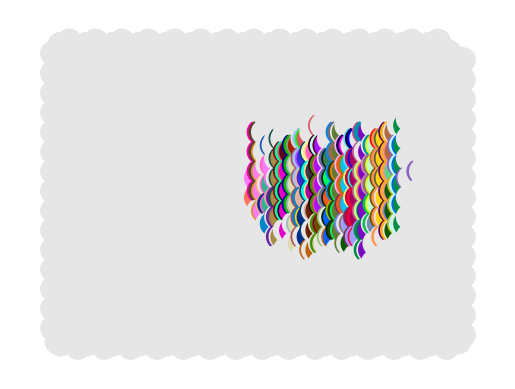

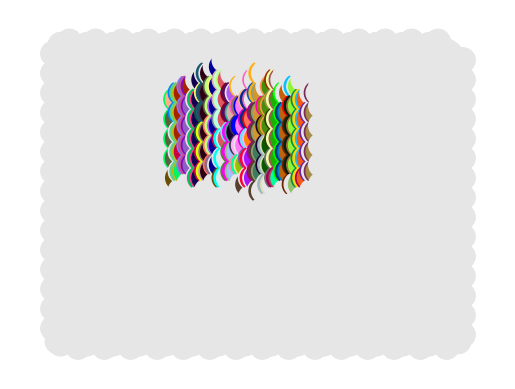

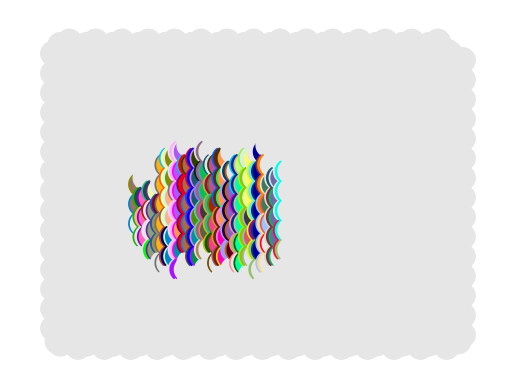

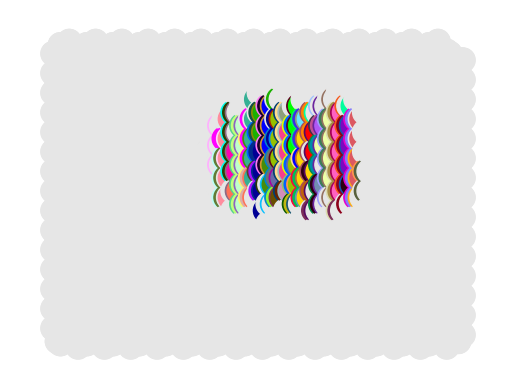

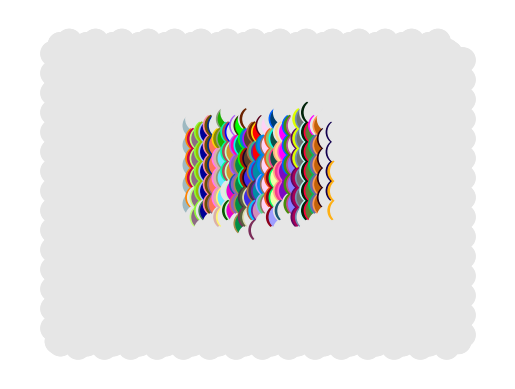

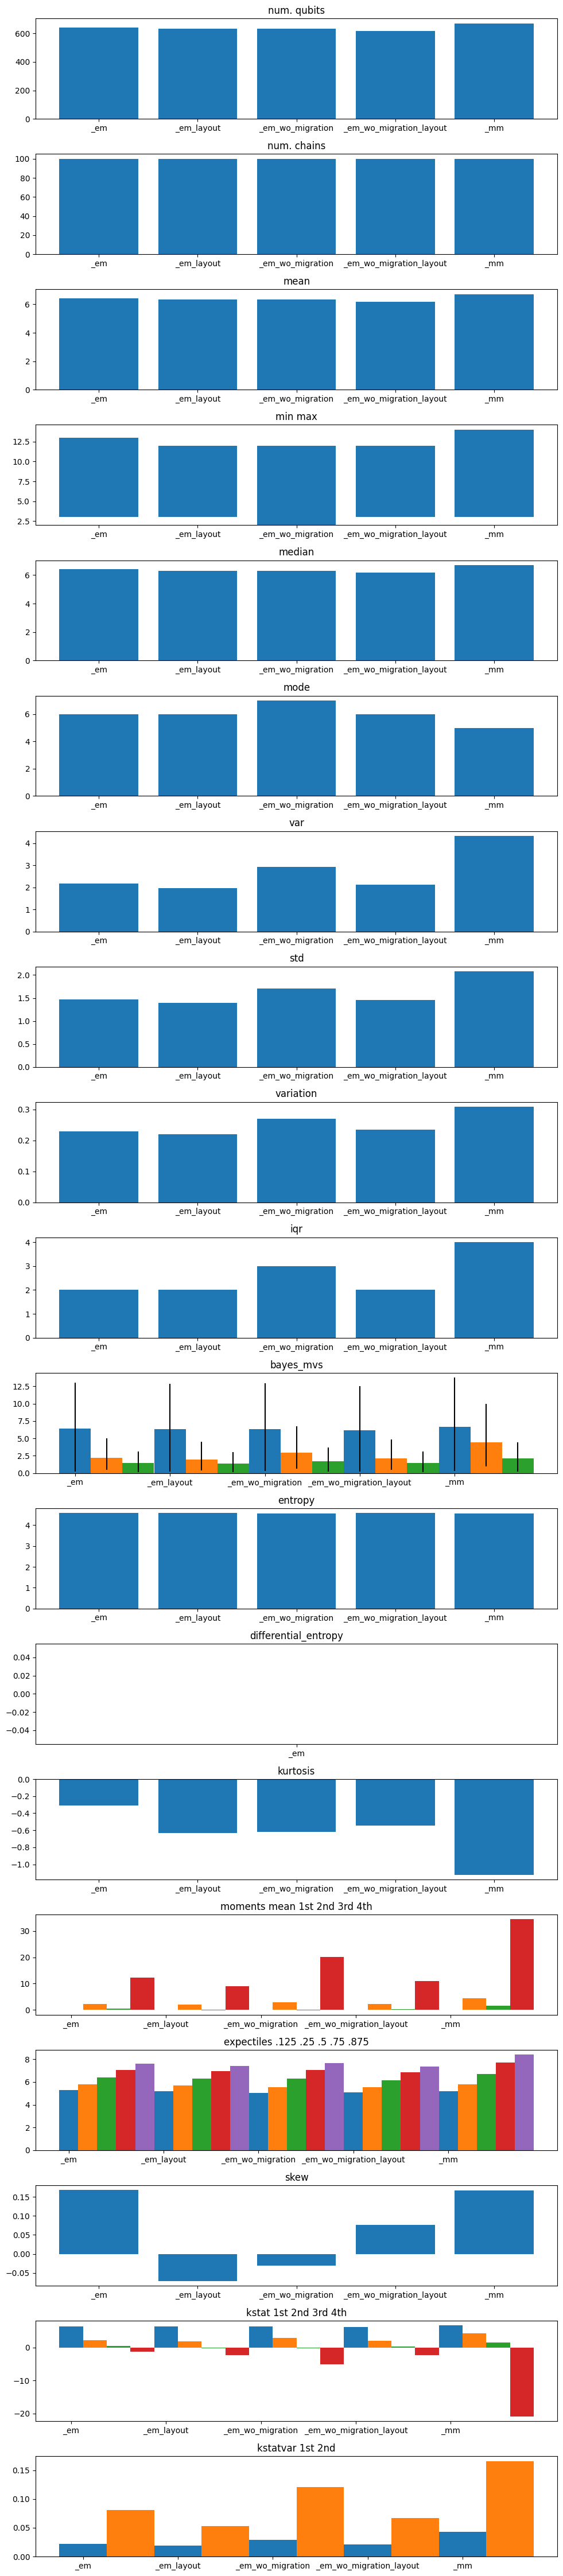

In [22]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import dimod
import dwave
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
import dwave_networkx as dnx
import minorminer
import embera

from src.particle_funcs import distance_matrix as distance_matrix
import src.leap_funcs.qubo.q_matrix as q_matrix

from src import leap_funcs as leap_funcs
from src.leap_funcs import embedding_quality

from src import h5py_funcs
from src.h5py_funcs import discoveries, init_custom_getstates, io

folder_path = 'test_analyze_embedding'
file_name = _file_name
file_name_path = os.path.join(folder_path, file_name)
with h5py.File(file_name_path, 'r') as file:
    keys = list(file.keys())
embs_stats = {}
for key in keys:
    if not key.startswith('embedding'):
        continue
    if key.endswith('_meta'):
        continue
    key = key[9:]
    emb = h5py_funcs.io.read_embedding_from_hdf5_file(file_name_path=file_name_path, data_name='embedding'+key)
    embs_stats[key] = leap_funcs.embedding_quality.analyze_embedding(emb)
for key, value in embs_stats.items():
    print(key, value)

names_embs = list(embs_stats.keys())
num_stats_per_emb = len(embs_stats[names_embs[0]]['metrics chain_lengths'])
names_stats = list(embs_stats[names_embs[0]]['metrics chain_lengths'].keys())
%matplotlib inline
fig, axs = plt.subplots(2+num_stats_per_emb,1, figsize=(10,45))
axs[0].bar(names_embs, [embs_stats[key]['num. qubits'] for key in names_embs])
axs[0].set_title('num. qubits')
axs[1].bar(names_embs, [embs_stats[key]['num. chains'] for key in names_embs])
axs[1].set_title('num. chains')
for i in range(num_stats_per_emb):
    #print(names_stats[i])
    x_pos = np.arange(len(names_embs))
    x_labels = names_embs
    if names_stats[i] =='min max':
        data = [embs_stats[key]['metrics chain_lengths'][names_stats[i]] for key in names_embs]
        axs[i+2].bar(x_pos, [d[1] for d in data], bottom=[d[0] for d in data])
        axs[i+2].set_title(names_stats[i])
        axs[i+2].set_xticks(x_pos, x_labels)
        #axs[i+2].set_xticklabels = x_labels
    elif names_stats[i] =='mode':
        data = [embs_stats[key]['metrics chain_lengths'][names_stats[i]] for key in names_embs]
        axs[i+2].bar(names_embs, [d[0] for d in data])
        axs[i+2].set_title(names_stats[i])
    elif names_stats[i] =='bayes_mvs':
        width = 0.333
        data = [embs_stats[key]['metrics chain_lengths'][names_stats[i]] for key in names_embs]
        for j in range(len(data[0])):
            axs[i+2].bar(x_pos+j*width, [d[j][0] for d in data], yerr=np.array([d[j][1] for d in data]).transpose(), width=width)
        axs[i+2].set_title(names_stats[i])
        axs[i+2].set_xticks(x_pos, x_labels)
    elif names_stats[i] =='moments mean 1st 2nd 3rd 4th':
        width = 0.25
        data = [embs_stats[key]['metrics chain_lengths'][names_stats[i]] for key in names_embs]
        for j in range(len(data[0])):
            axs[i+2].bar(x_pos+j*width, [d[j] for d in data], width=width)
        axs[i+2].set_title(names_stats[i])
        axs[i+2].set_xticks(x_pos, x_labels)
    elif names_stats[i] =='expectiles .125 .25 .5 .75 .875':
        width = 0.2
        data = [embs_stats[key]['metrics chain_lengths'][names_stats[i]] for key in names_embs]
        for j in range(len(data[0])):
            axs[i+2].bar(x_pos+j*width, [d[j] for d in data], width=width)
        axs[i+2].set_title(names_stats[i])
        axs[i+2].set_xticks(x_pos, x_labels)
    elif names_stats[i] =='kstat 1st 2nd 3rd 4th':
        width = 0.25
        data = [embs_stats[key]['metrics chain_lengths'][names_stats[i]] for key in names_embs]
        for j in range(len(data[0])):
            axs[i+2].bar(x_pos+j*width, [d[j] for d in data], width=width)
        axs[i+2].set_title(names_stats[i])
        axs[i+2].set_xticks(x_pos, x_labels)
    elif names_stats[i] =='kstatvar 1st 2nd':
        width = 0.5
        data = [embs_stats[key]['metrics chain_lengths'][names_stats[i]] for key in names_embs]
        for j in range(len(data[0])):
            axs[i+2].bar(x_pos+j*width, [d[j] for d in data], width=width)
        axs[i+2].set_title(names_stats[i])
        axs[i+2].set_xticks(x_pos, x_labels)
    else:
        axs[i+2].bar(names_embs, [embs_stats[key]['metrics chain_lengths'][names_stats[i]] for key in names_embs])
        axs[i+2].set_title(names_stats[i])
fig.tight_layout()
